In [86]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [87]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [88]:
#nltk.download()

# Loading Data and Pre-processing

In [89]:
my_columns = [
    'user_id', #1 user identifier
    'status_id', #1 status identifier
    #'created_at', #1 before or after debate
    #'screen_name', #1 profile screen name 
    'text', #1 tweet text
    'Y/N', #1 LABEL
    'display_text_width', #1 length
    'is_quote', #1 Whether the tweet is an original one or quoted one
    'favorite_count', #1
    'retweet_count',  #1
    #'quote_count', #1 All blank
    #'reply_count', #1 All blank
    'hashtags', #1
    'media_type', #1 contains just text or media (media = photo / video) contents: ‘photo’ / BLANK -> 'text'
    'mentions_screen_name', #1 Name
    #'quoted_source', #? TO BE DECIDED
    'followers_count', #1 info related to profile
    'friends_count', #1 info related to profile
    'listed_count', #1 info related to profile TO BE DECIDED
    'statuses_count', #1 info related to profile
    'favourites_count', #1 info related to profile
    'verified', #1 whether the profile is verified
]

In [195]:
file_name = 'proudboys-labelled.csv'
data = pd.read_csv(file_name, encoding='ISO-8859-1')
data = data[my_columns]
print(data.shape)

(2014, 17)


**Processing the Labels**

- Remove unlabled data
- Replace the original labels

In [196]:
# Remove the unlabeled data
data = data.dropna(subset=['Y/N'])
print(data.shape)

(2014, 17)


In [197]:
data['supportive'] = data['Y/N'].str.contains('Y')
data['offensive'] = data['Y/N'].str.contains('O')

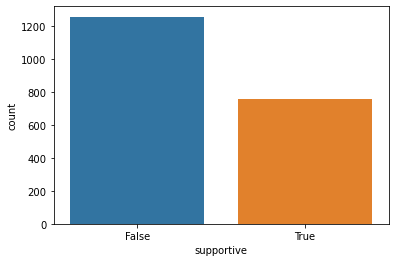

False    1257
True      757
Name: supportive, dtype: int64
False    1712
True      302
Name: offensive, dtype: int64


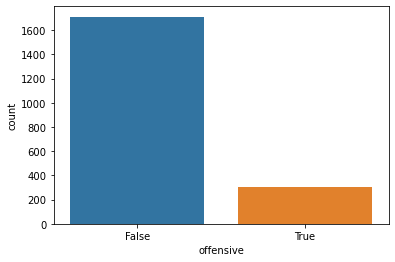

In [154]:
sns.countplot(data=data, x='supportive')
plt.show()
print(data['supportive'].value_counts())
sns.countplot(data=data, x='offensive')
print(data['offensive'].value_counts())

In [155]:
data['media_type'] = data['media_type'].fillna('plain_text')

**Processing the Hashtags**

Replace:
    
- 'alllivesmatters' -> 'alllivesmatter'
- 'antifacist', 'antifascists' -> 'antifa'
- 'blacklivesmatter', 'blacklivesstillmatter', 'blacklivesmatter' -> 'blm'
- 'kag2020' -> 'kag'
- 'maga2020' -> 'maga'
- 'oregoncity' -> 'oregon'
- 'portlandprotestors' -> 'portlandprotesters'
- 'protests', 'protest2020', 'protests2020' -> 'protest'
- 'trump2020' -> 'trump'

In [156]:
data['hashtags_proc'] = data['hashtags'].str.lower()
data['hashtags_proc'] = data['hashtags_proc'].fillna('blank')

ht_replacements = {
    'alllivesmatters': 'alllivesmatter',
    'antifacist': 'antifa',
    'antifascists':'antifa',
    'blacklivesmatter': 'blm',
    'blacklivesstillmatter': 'blm',
    'blacklivematter': 'blm',
    'kag2020': 'kag',
    'maga2020': 'maga',
    'oregoncity': 'oregon',
    'portlandprotestors': 'portlandprotesters',
    'protests': 'protest',
    'protest2020': 'protest',
    'protests2020': 'protest',
    'trump2020': 'trump',
}

for k, v in ht_replacements.items():
    data['hashtags_proc'] = data['hashtags_proc'].str.replace(k, v, regex=True)

## Adding New Features

In [157]:
data['hashtags_count'] = data['hashtags'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['hashtags_count'] = data['hashtags_count'].apply(lambda n: 3 if n > 2 else n)

data['hashtags_count'].head()

0    0
1    0
2    0
3    1
4    0
Name: hashtags_count, dtype: int64

In [158]:
data['mention_count'] = data['mentions_screen_name'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['mention_count'] = data['mention_count'].apply(lambda n: 4 if n > 3 else n)

data['mention_count'].head()

0    0
1    2
2    0
3    0
4    2
Name: mention_count, dtype: int64

In [159]:
data['exclamation_count'] = data['text'].str.count('\!')
data['exclamation_count'] = data['exclamation_count'].apply(lambda n: 3 if n > 2 else n)

data['question_count'] = data['text'].str.count('\?')
data['question_count'] = data['question_count'].apply(lambda n: 3 if n > 2 else n)

In [99]:
#data.info()
#print(data['is_quote'].value_counts())
#print(data['media_type'].value_counts())
#print(data['verified'].value_counts())
#print(data['supportive'].value_counts())
#print(data['offensive'].value_counts())
#print(data['exclamation_count'].value_counts())
#print(data['question_count'].value_counts())
#print(data['hashtags_count'].value_counts())
#print(data['mention_count'].value_counts())
#print(data['followers_count'].value_counts().sort_index())

### Remove URLs, Hashtags, Mentions

In [198]:
data['text_proc'] = data['text'].str.lower()
data['text_proc'] = data['text_proc'].str.replace(r"http\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"#\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"@\S+", "", regex=True)

Pre-processing Steps:

    1. Lower case
    2. Word tokenize
    3. Removing numbers and punctuations
    4. Word stemming

In [199]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word.isalpha()]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
    data.loc[idx, 'text_proc'] = ' '.join(words)
    

data.head()

,user_id,status_id,text,Y/N,display_text_width,is_quote,favorite_count,retweet_count,hashtags,media_type,...,followers_count,friends_count,listed_count,statuses_count,favourites_count,verified,supportive,offensive,text_proc,lem_text
0,x382691414,x1297365508300447744,Proud boys are attacking Peaceful protesters i...,N,115,False,0,0,NaN,photo,...,17949,10655,25,20274,20949,False,False,False,proud boy attack peac protest portland portlan...,proud boy attacking peaceful protester portlan...
1,x743936431,x1297365466306904066,"@Medde13 @MrAndyNgo I live in Portland, proud ...",N,189,False,0,0,NaN,NaN,...,16243,14907,16,32238,130281,False,False,False,live portland proud boy white supremacist hate...,live portland proud boy white supremacist hate...
2,x743936431,x1294749099976036353,Anyone else wondering why tRump and his deplor...,"N, O",175,False,9,0,NaN,NaN,...,16243,14907,16,32238,130281,False,False,True,anyon els wonder trump deplor base speak conde...,anyone else wondering trump deplorable base sp...
3,x375304364,x1297365456190406662,Not Antifa but the Right Wing Proud Boys. If y...,Y,126,True,0,0,CriticalThinking,NaN,...,135,196,2,9137,36815,False,True,False,antifa right wing proud boy think far left cau...,antifa right wing proud boy think far left cau...
4,x176941218,x1297365411533643776,@MARCIAN2003 @JoshuaPotash The police and the ...,N,42,False,0,0,NaN,NaN,...,1381,4135,20,33854,39852,False,False,False,polic proud boy,police proud boy


# Word Cloud

In [216]:
from PIL import Image
from wordcloud import WordCloud

#mask = np.array(Image.open('cloud.png'))
wc_o = WordCloud(background_color='white', max_words=200)#, mask=mask)
wc_offensive = wc_o.generate(' '.join(data[data['offensive'] == True]['lem_text']))

wc_no = WordCloud(background_color='white', max_words=200, mask=mask)
wc_nonoffensive = wc_no.generate(' '.join(data[data['offensive'] == False]['lem_text']))

wc_s = WordCloud(background_color='white', max_words=200, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=200, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['supportive'] == False]['lem_text']))

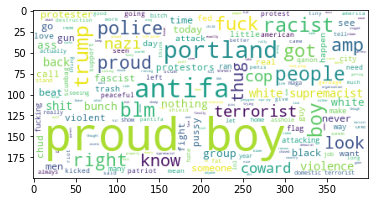

In [217]:
plt.imshow(wc_offensive)

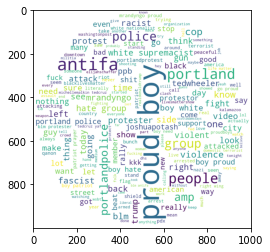

In [165]:
plt.imshow(wc_nonoffensive)

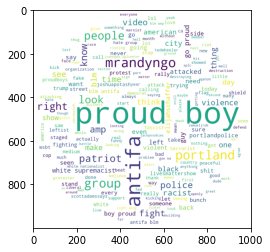

In [166]:
plt.imshow(wc_supportive)

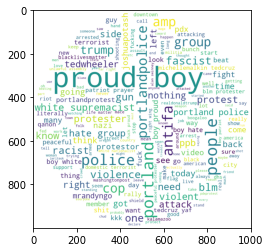

In [167]:
plt.imshow(wc_nonsupportive)

**Removing Common Words**

In [138]:
from collections import Counter
MOST_COMMON = 10
counter_supportive = Counter(" ".join(data["text_proc"][data['supportive'] == True]).split()).most_common(MOST_COMMON)
counter_nonsupportive = Counter(" ".join(data["text_proc"][data['supportive'] == False]).split()).most_common(MOST_COMMON)

In [139]:
df1 = pd.DataFrame(counter_supportive, columns =['word', 'freq_supportive'])
df1 = df1.set_index('word')
df2 = pd.DataFrame(counter_nonsupportive, columns=['word', 'freq_non_supportive'])
df2 = df2.set_index('word')

common_supportive = pd.concat([df1,df2],axis=1)
#print(common_supportive)

remove_supportive = []
for idx, row in common_supportive.iterrows():
    if row[0] > 0 and row[1] > 0:
        remove_supportive.append(idx)

In [140]:
print(len(remove_supportive), remove_supportive)
print(common_supportive)
remove_supportive = set(remove_supportive)

6 ['boy', 'proud', 'antifa', 'like', 'group', 'portland']
          freq_supportive  freq_non_supportive
boy                 795.0               1262.0
proud               790.0               1264.0
antifa              254.0                115.0
like                101.0                139.0
group                77.0                157.0
fight                69.0                  NaN
portland             62.0                207.0
look                 62.0                  NaN
blm                  58.0                  NaN
go                   58.0                  NaN
polic                 NaN                195.0
protest               NaN                168.0
peopl                 NaN                155.0
white                 NaN                104.0


In [141]:
for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word not in remove_supportive]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words])
    words = [stemmer.stem(word) for word in words]
    data.loc[idx, 'text_proc'] = ' '.join(words)

In [142]:
wc_s = WordCloud(background_color='white', max_words=200, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=200, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['supportive'] == False]['lem_text']))

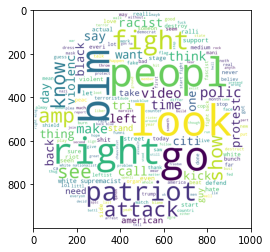

In [143]:
plt.imshow(wc_supportive)

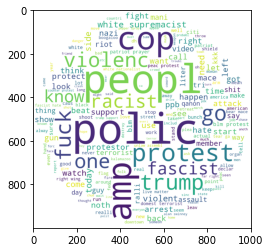

In [144]:
plt.imshow(wc_nonsupportive)

# Linguistic Features

Bag of Words (**X1**)

In [200]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000) # CountVectorizer(ngram_range=(2,2))
X1 = cv.fit_transform(data['text_proc']).toarray()

Term Frequence - Inverse Document Frequency (**X2**)

In [207]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=2000)
X2 = cv.fit_transform(data['text_proc']).toarray()

Word2Vec **NOTE**

In [ ]:
from gensim.models import Word2Vec
corpus = ' '.join(data['proc_text'])
#print(corpus)
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)
words = model.wv.vocab
print(len(words), len(data['proc_text']))

# To Do

WORD EMBEDDING **NOTE**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# To Do

Processing the Labels (**y**)

In [201]:
# Labels for Supportive / Non supportive
y = pd.get_dummies(data['supportive'])
y = y.iloc[:, 1].values
print(y[:6])

[0 0 0 1 0 0]


In [215]:
X_train.shape

(1611, 2000)

# Classifiers

Train Test Split (**X_train, y_train, X_test, y_test**)

In [208]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.20, random_state=0)

Naive Bayes

In [209]:
from sklearn.naive_bayes import MultinomialNB
model_NB = MultinomialNB().fit(X_train, y_train)

y_pred = model_NB.predict(X_test)

Random Forest

In [211]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=200, criterion='entropy').fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

In [212]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[203  55]
 [ 64  81]]


In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print(f'Accuracy: {accuracy*100}%, Precision: {precision*100}%, Recall: {recall*100}%, F1-score: {f1*100}%')

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       258
           1       0.60      0.56      0.58       145

    accuracy                           0.70       403
   macro avg       0.68      0.67      0.67       403
weighted avg       0.70      0.70      0.70       403

Accuracy: 70.47146401985111%, Precision: 59.55882352941176%, Recall: 55.86206896551724%, F1-score: 57.65124555160141%


 **BEFORE removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.76          | 0.65         | 0.72         | 0.68 
 Random Forest   | 0.73          | 0.62         | 0.66         | 0.64

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.79         | 0.40         | 0.53 
 Random Forest   | 0.75          | 0.72         | 0.50         | 0.59
 
 
 **AFTER removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.73          | 0.63         | 0.58         | 0.60

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.70          | 0.60         | 0.56         | 0.58

In [ ]:
from emoji import UNICODE_EMOJI

def is_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

In [ ]:
def extract_emojis(s):
    return ''.join(c for c in s if c in UNICODE_EMOJI)

In [ ]:
sns.boxplot(x='supportive',y='followers_count',data=data)

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x='followers_count',data=data)#,order=emp_length_order,hue='loan_status')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(data['followers_count'],kde=False,bins=40)
#plt.xlim(0,45000)